# Contrast Transfer Function
The Contrast Transfer Function (CTF) describes the aberrations of the objective lens in HRTEM and specifies how the condenser system shapes the probe in STEM. Here we describe how to create 

## Polar expansion of the phase error

Ideally, a lens forms a spherical wave converging on or emerging from a single point. In practice aberrations cause the wave to deviate from a spherical surface. This deviation can be represented as a phase error, $\chi(k, \phi)$ of the spatial frequency in polar coordinates. The phase error can be written a series expansion

$$ 
    \chi(\alpha, \phi) = \frac{2 \pi}{\lambda} \sum_{n,m} \frac{1}{n + 1} C_{n,m} (k \lambda)^{n+1} \cos\left[m (\phi - \phi_{n,m}) \right] \quad .
$$

If the microscope is well aligned then off-axis aberrations (astigmatisms) are small and the phase error is dominated by the first two isotropic terms

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f = -C_{1,1}$ is the defocus and $C_s=C_{3,3}$ is the third order spherical aberration.

The `CTF` object takes parameters of the form `Cnm` and `phinm`, and may also be given using their common alias e.g. `defocus = -C10`. The expansion is implemented up to 5th order, all the coefficients are shown in the table below.

abTEM exclusively use polar expansion coefficients, however, a conversion utility from the cartesian to the polar representation is avaiable `abtem.transfer.cartesian2polar`.

## Applying phase aberrations

We create a `CTF` object with an acceleration voltage of $300 \ \mathrm{keV}$, a spherical aberration of $0.7 \ \mathrm{mm}$ and a defocus of $-445 \ \mathrm{Angstrom}$ ([Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy)).

In [2]:
from abtem.utils import energy2wavelength
from abtem.transfer import CTF

Cs = 1.15e-3 * 1e10
defocus = (3 / 2 * Cs * energy2wavelength(300e3)) ** 0.5
ctf = CTF(defocus=defocus, Cs=Cs, energy=300e3)

We can use the function `plot_ctf` to preview the CTF along a radial.

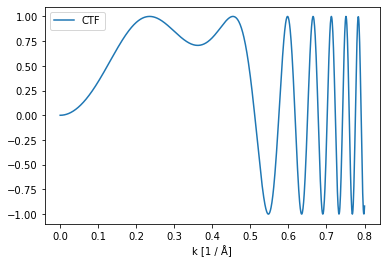

In [3]:
from abtem.plot import plot_ctf

plot_ctf(ctf, max_k=.8)

Given the exit wave function $\phi_{\mathrm{exit}}$ and the phase error $\chi$, the wave function at image plane is given by
$$
    \phi_{\mathrm{image}}(\alpha, \phi) = \phi_{\mathrm{exit}}(\alpha, \phi) \exp[-i \chi(\alpha, \phi)] \quad ,
$$
to perform this operation, we use the `apply_ctf` method. Here we apply the CTF to the exit wave from an earlier tutorial.

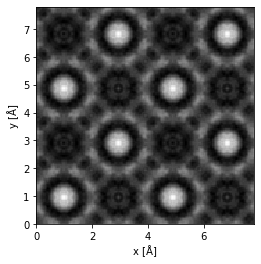

In [4]:
from abtem.waves import Waves
from abtem.plot import plot_image

exit_wave = Waves.read('srtio3_exit_wave.npz')
image_wave = exit_wave.apply_ctf(ctf)

plot_image(image_wave)

<div class= "alert alert-info">
**Note:**
 
The coefficients may also be given as a dictionary, for example:
    
```
coefficients = {'C10' : 1000, 'C30' : 1e6, 'C12' : 200, 'phi12' : .5}
ctf = CTF(**coefficients)
``` 
</div> 

## Aperture

The image above looks strange, this is because we have not limited . Applying an aperture function 

The aperture function cuts of high spatial frqeuecnes

$$
    A(k)= 
\begin{cases}
    1 & \text{if } x\geq k_{cut}\\
    0 & \text{if } x< k_{cut}
\end{cases}
$$



$$
    \phi_{\mathrm{image}}(\alpha, \phi) = \phi_{\mathrm{exit}}(\alpha, \phi) A(k) \exp[-i \chi(\alpha, \phi)] \quad ,
$$

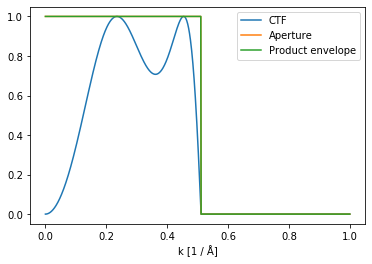

In [5]:
point_resolution = (energy2wavelength(300e3) ** 3 * Cs / 6) ** (1 / 4)
semiangle_cutoff = 1 / point_resolution * energy2wavelength(300e3)

ctf = CTF(defocus=defocus, Cs=Cs, energy=300e3, semiangle_cutoff=semiangle_cutoff)

plot_ctf(ctf, max_k=1.)

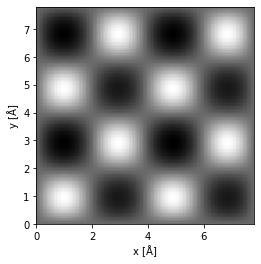

In [13]:
image_wave = exit_wave.apply_ctf(ctf)
plot_image(image_wave)

## Partial coherence

The aperture function cuts off beams scattered above a certain critical angle, however it is typically the partial coherence envelope function $E(k)$ that dampens the signal of beams scattered at high angles, and imposes a maximum to the transmitted spatial frequency. In abTEM the envlope function is constructed as a product of three envelopes

$$
    E(k) = E_s(k) E_t(k) E_d(k)
$$

### Partial spatial coherence
As the electron source has a finite size, the incident beam contains a distribution of incident directions. In HRTEM this is quantified by the angular spread. Assume that each incident direction performs its own experiment and that thedistribution of incident directions is small, then it can be shown that it can be modelled the spatial coherence envelope function, is given by

$$
    E_s(k) = \exp\left(-\frac{\beta}{4\lambda^2}\left| \frac{\partial \chi(k)}{\partial k}\right|^2  \right) .
$$

where $\beta$ is the $1/e$ width of the distribution of angles. The parameter $\beta$ is equivalent to the `angular_spread` property of the `CTF` object.

### Partial temporal coherence
A small spread in energy, $\Delta E$, of the incident electrons is equivalent to a small spread in defocus, due to the chromatic aberration of the objective lens. Fluctuations in the focusing currents, $\Delta I$, of the objective lens also produce an incoherent spread in defocus. Combining these effects, the $1/e$ width of the distribution of defocus values (the focal spread) can be written

$$
    \delta = C_c \sqrt{4 \left(\frac{\Delta I_\text{obj}}{I_\text{obj}}\right)^2 + \left(\frac{\Delta E}{V_\text{acc}}\right)^2 + \left(\frac{\Delta V_\text{acc}}{V_\text{acc}}\right)^2}
$$

The terms $\Delta I_\text{obj}/I_\text{obj}$ and $\Delta V_\text{acc}/V_\text{acc}$ represent instabilities in of the total current in the magnetic lenses and the acceleration voltage. $\Delta E/V_\text{acc}$ is the energy spread of electrons emitted by the source. Assuming that $\delta$ is small, it can be shown that focal spread can be approximated as

$$
    E_t(k) = \exp\left[-\frac{1}{2} \left(\pi \lambda \delta \right)^2 k^4 \right] .
$$

The parameter $\delta$ is equivalent to the `focal_spread` property of the `CTF` object.

### Deflections and thermal magnetic field noise
Blurring can also be caused by all kinds of noise leading to a random deflection of the image relative to the detector, such as vibrations, drift of the stage, and magnetic noise fields resulting from eddy currents in the material of the lenses. Assuming that the image deflection is small and follows a Gaussian distribution, this can be included as an additional envelope

$$
	E_d(k) = \exp\left(- \frac{\sigma^2 k^2 \lambda^2}{2}\right) ,
$$

where $\sigma$ is the $1/e$ width of the deflection. The parameter $\sigma$ is equivalent to the `blur` property of the `CTF` object.

Below we create a `CTF` object with all the sources of partial coeherence. In practice it is difficult to know the instrument well enough to estimate the parameters influencing partial coherence, we discuss this problem in XXX.

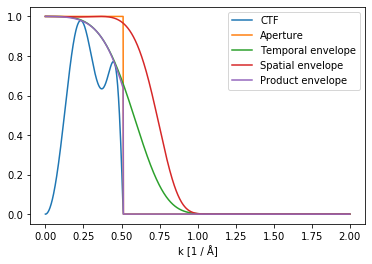

In [10]:
ctf.focal_spread = 80
ctf.angular_spread = .2e-3
ctf.blur = 20000
#ctf.cutoff = .015

#plot_ctf(ctf, max_k=2)
#ctf = CTF(defocus=defocus, Cs=Cs, energy=300e3)

#ctf.focal_spread = 60
#ctf.angular_spread = .2e-3
#ctf.blur = 2
#ctf.cutoff = .015

plot_ctf(ctf, max_k=2)